In [1]:
# import pandas as pd
# from xgboost import XGBRegressor
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error, r2_score

# # Load data
# df = pd.read_excel("Feature_engineering_DS.xlsx")

# # Define features (X) and target (y)
# X = df.drop(columns=["L8","date"])
# y = df["L8"]

# # Split into train/test
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42
# )

# # Initialize and train XGBoost model
# model = XGBRegressor(
#     n_estimators=500,
#     learning_rate=0.05,
#     max_depth=6,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     random_state=42,
#     objective='reg:squarederror'
# )

# model.fit(X_train, y_train)

# # Predictions
# y_pred = model.predict(X_test)

# # Evaluation
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print(f"Mean Squared Error: {mse:.4f}")
# print(f"R² Score: {r2:.4f}")



In [2]:
# X_train.head()


[0]	validation_0-rmse:0.96554
[1]	validation_0-rmse:0.92426
[2]	validation_0-rmse:0.88924
[3]	validation_0-rmse:0.85627
[4]	validation_0-rmse:0.82118
[5]	validation_0-rmse:0.79216
[6]	validation_0-rmse:0.76087
[7]	validation_0-rmse:0.73148
[8]	validation_0-rmse:0.70389
[9]	validation_0-rmse:0.67798
[10]	validation_0-rmse:0.65373
[11]	validation_0-rmse:0.63098
[12]	validation_0-rmse:0.60968
[13]	validation_0-rmse:0.58974
[14]	validation_0-rmse:0.57112
[15]	validation_0-rmse:0.55603
[16]	validation_0-rmse:0.54203
[17]	validation_0-rmse:0.52659
[18]	validation_0-rmse:0.51229
[19]	validation_0-rmse:0.49905
[20]	validation_0-rmse:0.48669
[21]	validation_0-rmse:0.47526
[22]	validation_0-rmse:0.46467
[23]	validation_0-rmse:0.45653
[24]	validation_0-rmse:0.44728
[25]	validation_0-rmse:0.43863
[26]	validation_0-rmse:0.43090
[27]	validation_0-rmse:0.42359
[28]	validation_0-rmse:0.41685
[29]	validation_0-rmse:0.41075
[30]	validation_0-rmse:0.40511
[31]	validation_0-rmse:0.39987
[32]	validation_0-

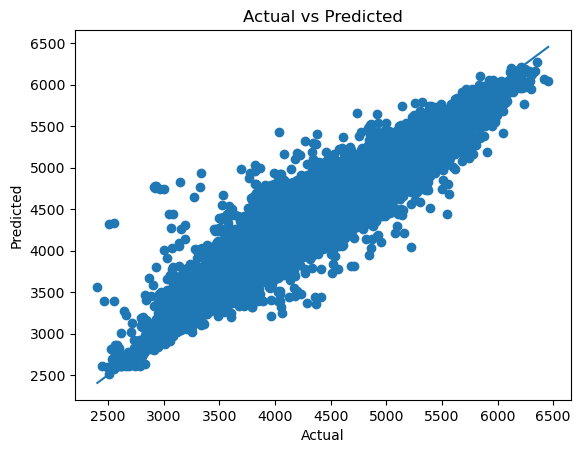

In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt

#===============================
# LOAD
#===============================
df = pd.read_excel("Feature_engineering_DS.xlsx")       # assumes target column is "target"

X = df.drop(["L8","date"], axis=1).values
y = df["L8"].values.reshape(-1,1)

#===============================
# SPLIT    train / val / test
#===============================
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)
# train 70%, val 15%, test 15%

#===============================
# SCALE (only fit on train)
#===============================
x_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train_s = x_scaler.fit_transform(X_train)
y_train_s = y_scaler.fit_transform(y_train)

X_val_s = x_scaler.transform(X_val)
y_val_s = y_scaler.transform(y_val)

X_test_s = x_scaler.transform(X_test)
y_test_s = y_scaler.transform(y_test)

#===============================
# TRAIN XGBOOST
#===============================
model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    tree_method="hist",
    random_state=42
)

model.fit(X_train_s, y_train_s.ravel(), eval_set=[(X_val_s, y_val_s.ravel())])

#===============================
# PREDICT + DE NORMALISE
#===============================
pred_s = model.predict(X_test_s).reshape(-1,1)

pred_real = y_scaler.inverse_transform(pred_s)
y_test_real = y_scaler.inverse_transform(y_test_s)

#===============================
# METRICS
#===============================
rmse = np.sqrt(mean_squared_error(y_test_real, pred_real))
mae  = mean_absolute_error(y_test_real, pred_real)
mse  = mean_squared_error(y_test_real, pred_real)
r2   = r2_score(y_test_real, pred_real)

print("RMSE:", rmse)
print("MAE :", mae)
print("MSE :", mse)
print("R2  :", r2)

#===============================
# GRAPH  (Actual vs Predicted)
#===============================
plt.figure()
plt.scatter(y_test_real, pred_real)
plt.plot([y_test_real.min(), y_test_real.max()],
         [y_test_real.min(), y_test_real.max()])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()


In [20]:
from scipy.stats import uniform, randint, loguniform

param_dist = {
    'n_estimators': randint(200, 2000),
    'learning_rate': loguniform(1e-4, 0.3),  # very important, log not uniform
    'max_depth': randint(2, 11),
    'min_child_weight': loguniform(1e-2, 10),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': loguniform(1e-8, 10),
    'reg_alpha': loguniform(1e-8, 5),
    'reg_lambda': loguniform(1e-8, 5)
}


In [21]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

In [22]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002ACEB8DF320>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002ACEA9B5E80>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002ACEA9B7980>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002ACEA2CB6B0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [23]:
# Retrieve the best model
best_xgb_model = random_search.best_estimator_

# Make predictions on the test set
y_pred_best_xgb = best_xgb_model.predict(X_test)

# Calculate evaluation metrics
best_xgb_mse = mean_squared_error(y_test, y_pred_best_xgb)
best_xgb_rmse = np.sqrt(best_xgb_mse)
best_xgb_r2 = r2_score(y_test, y_pred_best_xgb)
best_xgb_mae = mean_absolute_error(y_test, y_pred_best_xgb)

# Print the evaluation metrics
print(f"Best XGBoost Model Evaluation (on denormalized data):")
print(f"  Mean Squared Error (MSE): {best_xgb_mse:.4f}")
print(f"  Root Mean Squared Error (RMSE): {best_xgb_rmse:.4f}")
print(f"  R² Score: {best_xgb_r2:.4f}")
print(f"  MAE Score: {best_xgb_mae:.4f}")

Best XGBoost Model Evaluation (on denormalized data):
  Mean Squared Error (MSE): 33897.9151
  Root Mean Squared Error (RMSE): 184.1139
  R² Score: 0.9266
  MAE Score: 125.6167


RMSE: 3782159.8827590398
MAE : 3756170.800656179
MSE : 14304733378751.875
R2  : -71.86867151092791


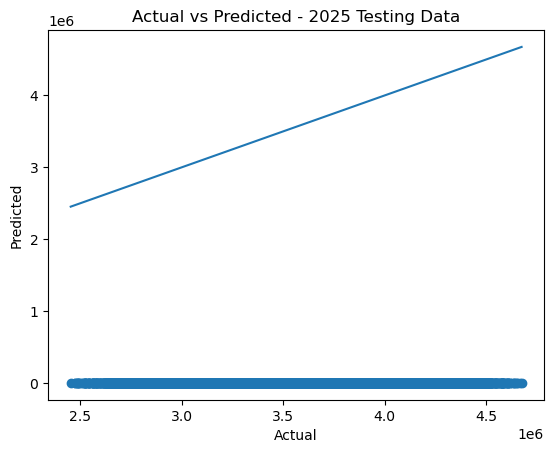

In [25]:
# ==========================
# 2025_testing evaluation
# ==========================
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 1) load file
df2 = pd.read_excel("2025_testing.xlsx")

# 2) drop SAME columns exactly like train
X_future = df2.drop(["L8","date"], axis=1).values
y_future = df2["L8"].values.reshape(-1,1)

# 3) scale X using SAME scaler (no fit!!!)
X_future_s = x_scaler.transform(X_future)

# 4) predict scaled
pred_future_s = model.predict(X_future_s).reshape(-1,1)

# 5) inverse transform
pred_future = y_scaler.inverse_transform(pred_future_s)
y_future_real = y_scaler.inverse_transform(y_future)

# 6) metrics
rmse = np.sqrt(mean_squared_error(y_future_real, pred_future))
mae  = mean_absolute_error(y_future_real, pred_future)
mse  = mean_squared_error(y_future_real, pred_future)
r2   = r2_score(y_future_real, pred_future)

print("RMSE:", rmse)
print("MAE :", mae)
print("MSE :", mse)
print("R2  :", r2)

# 7) graph Actual vs Predicted for 2025
plt.figure()
plt.scatter(y_future_real, pred_future)
plt.plot([y_future_real.min(), y_future_real.max()],
         [y_future_real.min(), y_future_real.max()])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted - 2025 Testing Data")
plt.show()


RMSE: 2022003.0970249944
MAE : 1972845.6287065165
MSE : 4088496524378.6694
R2  : -19.82690409672734


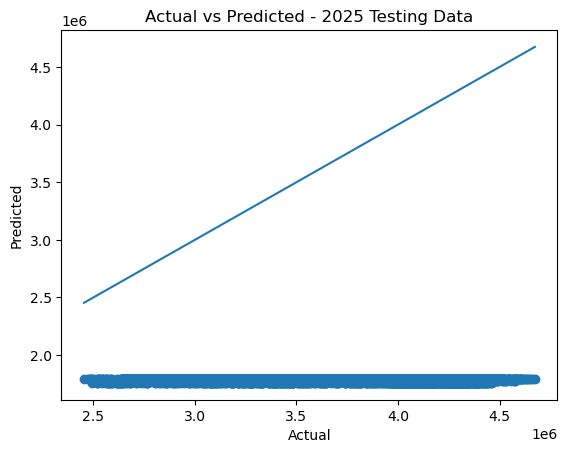

In [26]:
# ==========================
# 2025_testing evaluation
# ==========================
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 1) load file
df2 = pd.read_excel("2025_testing.xlsx")

# 2) drop SAME columns exactly like train
X_future = df2.drop(["L8","date"], axis=1).values
y_future = df2["L8"].values.reshape(-1,1)

# 3) scale X using SAME scaler (no fit!!!)
X_future_s = x_scaler.transform(X_future)

# 4) predict scaled
pred_future_s = best_xgb_model.predict(X_future_s).reshape(-1,1)

# 5) inverse transform
pred_future = y_scaler.inverse_transform(pred_future_s)
y_future_real = y_scaler.inverse_transform(y_future)

# 6) metrics
rmse = np.sqrt(mean_squared_error(y_future_real, pred_future))
mae  = mean_absolute_error(y_future_real, pred_future)
mse  = mean_squared_error(y_future_real, pred_future)
r2   = r2_score(y_future_real, pred_future)

print("RMSE:", rmse)
print("MAE :", mae)
print("MSE :", mse)
print("R2  :", r2)

# 7) graph Actual vs Predicted for 2025
plt.figure()
plt.scatter(y_future_real, pred_future)
plt.plot([y_future_real.min(), y_future_real.max()],
         [y_future_real.min(), y_future_real.max()])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted - 2025 Testing Data")
plt.show()
